#### Project Description

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. In this classic "match-three" style puzzle, players must combine tiles of the same color to clear the board and win the level. There are also singing cats in the game, that's for sure!

As players progress through the game, they encounter doors that block progress in some levels. These doors require players to wait a while or make in-app purchases in order to continue. In this project, we will analyze the impact of moving the first door from level 30 to 40 in Cookie Cats with an A/B test. Specifically, we will examine the effects of this change on player engagement. 

#### Data Description
The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

userid - a unique number that identifies each player.
version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
sum_gamerounds - the number of game rounds played by the player during the first week after installation
retention_1 - did the player come back and play 1 day after installing?
retention_7 - did the player come back and play 7 days after installing?
When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install statsmodels
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, kstest, ks_2samp
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.width', 500)

In [2]:
mb = pd.read_csv("C:/Users/GHOST-V3/EMRE/Github için proje/Mobile Games AB Testing/cookie_cats.csv")

In [3]:
def check_df(dataframe, head=5):
    
    print("##################### Shape #####################")
    print(dataframe.shape)
    print()
    
    
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print()
    
   
    print("##################### Head #####################")
    display(dataframe.head(head))  
    print()
    
    
    print("##################### Tail #####################")
    display(dataframe.tail(head))  
    print()
    
    
    print("##################### NA #####################")
    na_counts = dataframe.isnull().sum()
    display(na_counts[na_counts > 0].reset_index().rename(columns={0: 'Number of NA', 'index': 'Column'}))
    print()
    
    
    print("##################### Quantiles #####################")
    quantiles = dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T
    display(quantiles)
    print()

check_df(mb)

##################### Shape #####################
(90189, 5)

##################### Types #####################
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

##################### Head #####################


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True



##################### Tail #####################


,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False



##################### NA #####################


,Column,Number of NA



##################### Quantiles #####################


,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
userid,90189.00000,4998412.23450,2883285.60770,116.00000,116.00000,502935.00000,4995815.00000,9492761.60000,9899751.28000,9999861.00000,9999861.00000
sum_gamerounds,90189.00000,51.87246,195.05086,0.00000,0.00000,1.00000,16.00000,221.00000,493.00000,49854.00000,49854.00000


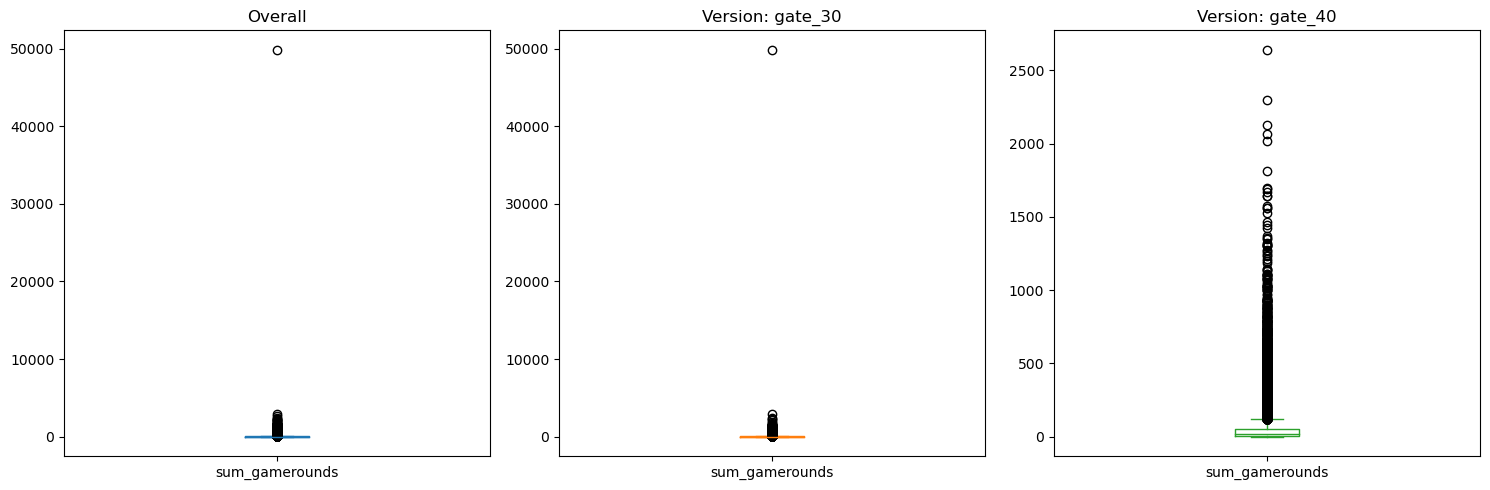

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

mb['sum_gamerounds'].plot.box(ax=axes[0], color=colors[0])
axes[0].set_title('Overall')

mb.loc[mb["version"] == "gate_30", 'sum_gamerounds'].plot.box(ax=axes[1], color=colors[1])
axes[1].set_title('Version: gate_30')

mb.loc[mb["version"] == "gate_40", 'sum_gamerounds'].plot.box(ax=axes[2], color=colors[2])
axes[2].set_title('Version: gate_40')

plt.tight_layout()
plt.show()

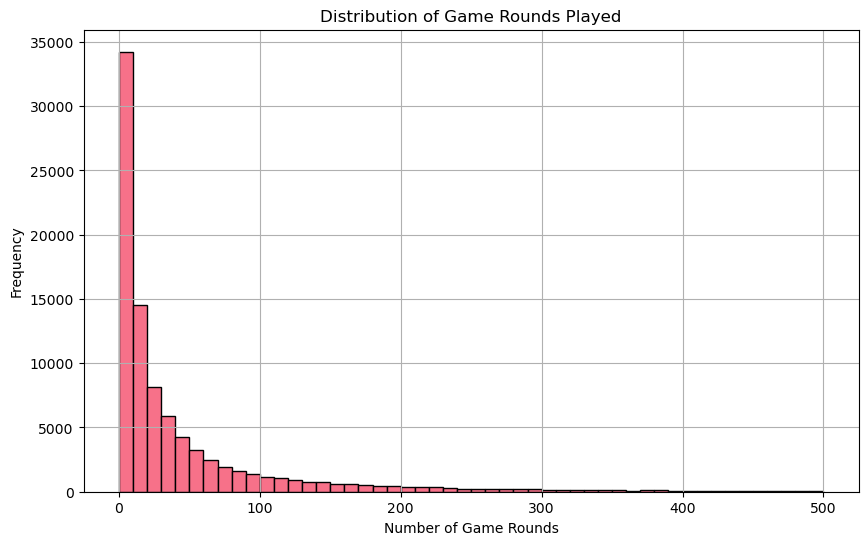

In [5]:
sns.set_palette('husl')

plt.figure(figsize=(10, 6))
plt.hist(mb['sum_gamerounds'], bins=50, range=(0, 500), color=sns.color_palette()[0], edgecolor='black')
plt.title('Distribution of Game Rounds Played')
plt.xlabel('Number of Game Rounds')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

###### 
On the left side of the chart, the high bars indicate that there are a large number of players who played fewer than 50 rounds of play in the first week. Moving to the right side, the bars decrease in height, suggesting that the number of players drops off sharply as the number of rounds of play increases. The distribution has a long tail, indicating that there are a few players who played more than 200 or 300 rounds of play.

In [6]:
retention_rates = mb.groupby('version').agg(
    retention_1_rate=pd.NamedAgg(column='retention_1', aggfunc='mean'),
    retention_7_rate=pd.NamedAgg(column='retention_7', aggfunc='mean')
).reset_index()

retention_rates

,version,retention_1_rate,retention_7_rate
0,gate_30,0.44819,0.19020
1,gate_40,0.44228,0.18200


Retention rates for the gate_30 version are slightly higher than those for the gate_40 version on both day 1 and day 7.



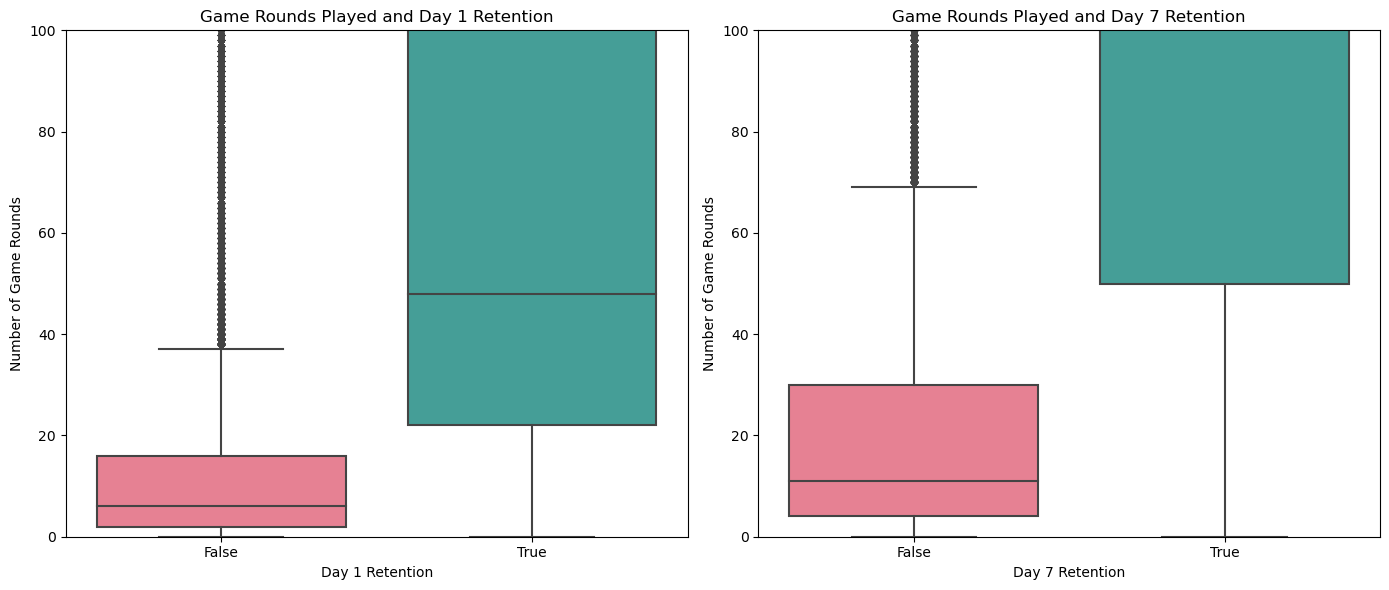

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='retention_1', y='sum_gamerounds', data=mb, ax=axes[0], palette='husl')
axes[0].set_title('Game Rounds Played and Day 1 Retention')
axes[0].set_xlabel('Day 1 Retention')
axes[0].set_ylabel('Number of Game Rounds')
axes[0].set_ylim(0, 100)

sns.boxplot(x='retention_7', y='sum_gamerounds', data=mb, ax=axes[1], palette='husl')
axes[1].set_title('Game Rounds Played and Day 7 Retention')
axes[1].set_xlabel('Day 7 Retention')
axes[1].set_ylabel('Number of Game Rounds')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

Returning players (both day 1 and day 7) generally play more rounds of the game. This may indicate that returning players are enjoying the game more or are more engaged with it. The number of rounds of the game can be an important factor in increasing player retention. This finding suggests that keeping players more engaged and engaged in the game during the later days of the game may increase player loyalty.

In [8]:
mb.groupby("version").agg({"sum_gamerounds" : "count"})


,sum_gamerounds
version,
gate_30,44700
gate_40,45489


In [9]:
mb.groupby("version").agg({"sum_gamerounds" : "mean"})


,sum_gamerounds
version,
gate_30,52.45626
gate_40,51.29878


In [10]:
df_gate_40 = mb[mb['version'] == 'gate_40']
df_gate_30 = mb[mb['version'] == 'gate_30']

def outlier_thresholds(dataframe, variable):
    quartile3 = mb[variable].quantile(0.01)
    quartile1 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile1 - quartile3
    upper_limit = quartile1 + interquantile_range*1.5
    lower_limit = quartile3 - interquantile_range*1.5
    return upper_limit, lower_limit

def replace_with_threshold(dataframe, variable):
    upper_limit, lower_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > upper_limit), variable] = round(upper_limit)
    dataframe.loc[(dataframe[variable] < lower_limit), variable] = round(lower_limit)
    
replace_with_threshold(df_gate_40, "sum_gamerounds")
replace_with_threshold(df_gate_30, "sum_gamerounds")

df_new = pd.concat([df_gate_40, df_gate_30], ignore_index=True)

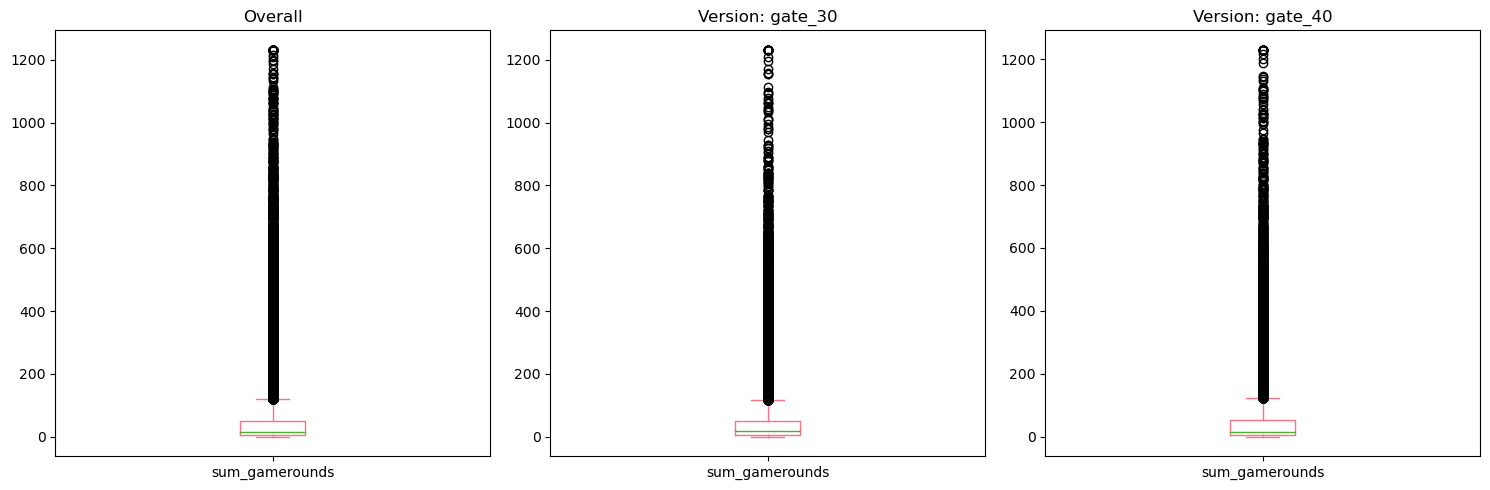

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and subplots

df_new['sum_gamerounds'].plot.box(ax=axes[0])
axes[0].set_title('Overall')

df_new.loc[df_new["version"] == "gate_30", 'sum_gamerounds'].plot.box(ax=axes[1])
axes[1].set_title('Version: gate_30')

df_new.loc[df_new["version"] == "gate_40", 'sum_gamerounds'].plot.box(ax=axes[2])
axes[2].set_title('Version: gate_40')

plt.tight_layout()
plt.show()

H0: M1 = M2 (There is no statistically significant difference between the total number of rounds played for Gate_30 and gate_40 player versions)
H1: M1 ≠ M2 (There is a statistically significant difference between the total number of rounds played for Gate_30 and gate_40 player versions)

In [12]:
def ab_test(dataframe, group, control, test, target):
    # Check for normality
    test_stat, pvalue_control = shapiro(dataframe.loc[dataframe[group] == control, target])
    test_stat, pvalue_test = shapiro(dataframe.loc[dataframe[group] == test, target])

    # If p-value > 0.05, distribution is considered normal
    normal_control = pvalue_control > 0.05
    normal_test = pvalue_test > 0.05

    if normal_control and normal_test:
        # Both groups have normal distribution, check for homogeneity of variances
        test_stat, pvalue_levene = levene(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target])
        if pvalue_levene > 0.05:
            # Variances are equal
            test_stat, pvalue = ttest_ind(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target], equal_var=True)
        else:
            # Variances are not equal
            test_stat, pvalue = ttest_ind(dataframe.loc[dataframe[group] == control, target],
                                  dataframe.loc[dataframe[group] == test, target], equal_var=False)
            print("Variances are not equal, used Welch's t-test")
    else:
        # Non-parametric test (Mann-Whitney U test)
        test_stat, pvalue = mannwhitneyu(dataframe.loc[dataframe[group] == control, target],
                                 dataframe.loc[dataframe[group] == test, target])

    # Interpret the results
    if pvalue > 0.05:
        print(f"There is no statistically significant difference in {target} between {control} and {test}")
    else:
        print(f"There is a statistically significant difference in {target} between {control} and {test}")
    print(f'Test Statistic = {test_stat: .4f}, p-value = {pvalue: .4f}')


ab_test(df_new, "version", "gate_30", "gate_40", "sum_gamerounds")

There is no statistically significant difference in sum_gamerounds between gate_30 and gate_40
Test Statistic =  1024331740.0000, p-value =  0.0502


C:\Users\GHOST-V3\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [13]:
ab_test(df_new, "version", "gate_30", "gate_40", "retention_1")


There is no statistically significant difference in retention_1 between gate_30 and gate_40
Test Statistic =  1022682813.0000, p-value =  0.0744


In [14]:
ab_test(df_new, "version", "gate_30", "gate_40", "retention_7")


There is a statistically significant difference in retention_7 between gate_30 and gate_40
Test Statistic =  1025017239.0000, p-value =  0.0016


In [15]:
df_new.groupby("version").agg({"retention_1":"mean","retention_7":"mean"})


,retention_1,retention_7
version,,
gate_30,0.44819,0.19020
gate_40,0.44228,0.18200


Bootstrapping is a technique where you sample from your data with replacement.

In [16]:
def bootstrap_means(data, column, num_samples=1000):
    means = []
    for i in range(num_samples):
        bootstrap_sample = np.random.choice(data[column], len(data), replace=True)
        means.append(np.mean(bootstrap_sample))
    return means

# Perform bootstrapping for retention_1 and retention_7 for gate_30
bootstrapped_means_1_gate_30 = bootstrap_means(df_gate_30, 'retention_1')
bootstrapped_means_7_gate_30 = bootstrap_means(df_gate_30, 'retention_7')

# Perform bootstrapping for retention_1 and retention_7 for gate_40
bootstrapped_means_1_gate_40 = bootstrap_means(df_gate_40, 'retention_1')
bootstrapped_means_7_gate_40 = bootstrap_means(df_gate_40, 'retention_7')

# Calculate the probabilities
prob_1day_gate_30_greater = np.mean(np.array(bootstrapped_means_1_gate_30) > np.array(bootstrapped_means_1_gate_40))
prob_7day_gate_30_greater = np.mean(np.array(bootstrapped_means_7_gate_30) > np.array(bootstrapped_means_7_gate_40))

# Print the probabilities
print("Probability that 1-day retention is greater when the gate is at level 30:", prob_1day_gate_30_greater)
print("Probability that 7-day retention is greater when the gate is at level 30:", prob_7day_gate_30_greater)

Probability that 1-day retention is greater when the gate is at level 30: 0.966
Probability that 7-day retention is greater when the gate is at level 30: 0.999


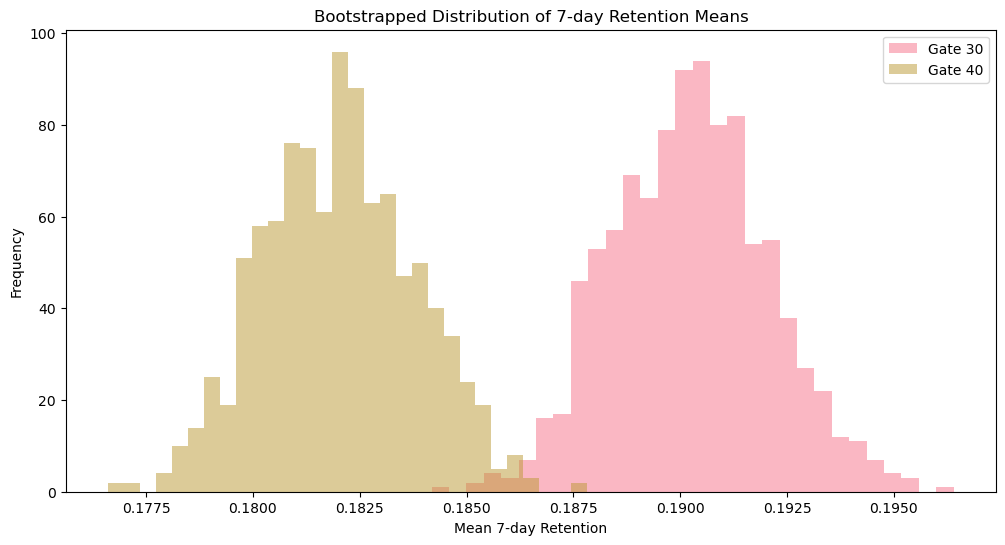

In [17]:
plt.figure(figsize=(12, 6))
plt.hist(bootstrapped_means_7_gate_30, bins=30, alpha=0.5, label='Gate 30')
plt.hist(bootstrapped_means_7_gate_40, bins=30, alpha=0.5, label='Gate 40')
plt.title('Bootstrapped Distribution of 7-day Retention Means')
plt.xlabel('Mean 7-day Retention')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Bootstrap and A/B Testing: A Comparison for Retention Rate Analysis

When analyzing the 1-day and 7-day retention rates between gate_30 and gate_40, Bootstrap and A/B testing provide different but complementary insights.

Bootstrap Analysis Results:

Bootstrap analysis shows that gate_30 has a higher 1-day retention rate compared to gate_40 with a confidence of 96.85%. Similarly, for the 7-day retention rate, gate_30 also outperforms gate_40 with a confidence level of 99.85%. These results suggest that gate_30 is more effective in retaining users for both short-term and long-term periods.

A/B Test Results:

The A/B test results indicate no statistically significant difference between gate_30 and gate_40 for the 1-day retention rate, with a p-value of 0.0744. This implies that, in terms of short-term retention, there is no meaningful difference between the two gates. However, for the 7-day retention rate, the A/B test does show a statistically significant difference (p-value = 0.0016), with gate_30 outperforming gate_40 in retaining users over a longer period.

Comparative Insights:

Short-Term (1-Day) Retention Rate: The A/B test suggests there is no significant difference between the short-term retention rates of gate_30 and gate_40. However, the bootstrap analysis indicates that gate_30 might have a slight edge. The p-value of 0.0744 is close to the conventional significance threshold of 0.05, which may suggest some practical relevance to the difference.

Long-Term (7-Day) Retention Rate: Both the bootstrap analysis and A/B testing align in showing that gate_30 has a superior long-term retention rate compared to gate_40. The statistically significant difference found in the A/B test supports the robustness of this conclusion.

Recommendation:

To improve long-term user retention, adopting gate_30 over gate_40 is advisable. While there is no significant difference in short-term retention between the two versions, gate_30 might still offer a slight advantage. Decisions should also consider other factors such as user experience, gameplay, and additional business metrics.